In [3]:
import numpy as np

def read_fvecs(filename):
    with open(filename, 'rb') as f:
        # 읽기
        data = np.fromfile(f, dtype='int32')
        # 첫 번째 값을 차원으로 사용
        dim = data[0]
        # 데이터 변환 및 리턴
        return data.reshape(-1, dim + 1)[:, 1:].astype('float32')

def read_ivecs(filename):
    with open(filename, 'rb') as f:
        # 읽기
        data = np.fromfile(f, dtype='int32')
        # 첫 번째 값을 차원으로 사용
        dim = data[0]
        # 데이터 변환 및 리턴
        return data.reshape(-1, dim + 1)[:, 1:]

# 파일 경로 설정
base_path = '/data/matmang/gist/gist_base.fvecs'
learn_path = '/data/matmang/gist/gist_learn.fvecs'
query_path = '/data/matmang/gist/gist_query.fvecs'
groundtruth_path = '/data/matmang/gist/gist_groundtruth.ivecs'

# 파일 읽기
gist_base = read_fvecs(base_path)
gist_learn = read_fvecs(learn_path)
gist_query = read_fvecs(query_path)
gist_groundtruth = read_ivecs(groundtruth_path)

print(f'Base shape: {gist_base.shape}')
print(f'Learn shape: {gist_learn.shape}')
print(f'Query shape: {gist_query.shape}')
print(f'Groundtruth shape: {gist_groundtruth.shape}')

Base shape: (1000000, 960)
Learn shape: (500000, 960)
Query shape: (1000, 960)
Groundtruth shape: (1000, 100)


In [4]:
import faiss

# 차원 수
dim = gist_base.shape[1]

# FlatL2 인덱스 생성 및 학습
index_flat = faiss.IndexFlatL2(dim)
index_flat.add(gist_base)

# IVF 인덱스 생성 및 학습
nprove = 100  # Number of clusters
quantizer = faiss.IndexFlatL2(dim)
index_ivf = faiss.IndexIVFFlat(quantizer, dim, nprove)
index_ivf.train(gist_learn)
index_ivf.add(gist_base)

# HNSW 인덱스 생성 및 학습
index_hnsw = faiss.IndexHNSWFlat(dim, 32)
index_hnsw.add(gist_base)

In [5]:
import time

def search_and_measure(index, queries, groundtruth, k=5):
    start_time = time.time()
    distances, indices = index.search(queries, k)
    query_time = time.time() - start_time
    
    recall = []
    for i, neighbors in enumerate(indices):
        gt = set(groundtruth[i])
        retrieved = set(neighbors)
        correct = len(gt & retrieved)
        recall.append(correct / len(gt))
    
    avg_recall = np.mean(recall)
    avg_query_time = query_time / len(queries)
    
    return avg_recall, avg_query_time

In [6]:
k_values = [1, 5, 10, 20, 50, 100]  # 다양한 k 값

# 인덱스별로 성능 측정
results = {'FlatL2': [], 'IVF': [], 'HNSW': []}
indices = [index_flat, index_ivf, index_hnsw]

for k in k_values:
    for idx, name in zip(indices, results.keys()):
        recall, query_time = search_and_measure(idx, gist_query, gist_groundtruth, k)
        results[name].append((recall, query_time))

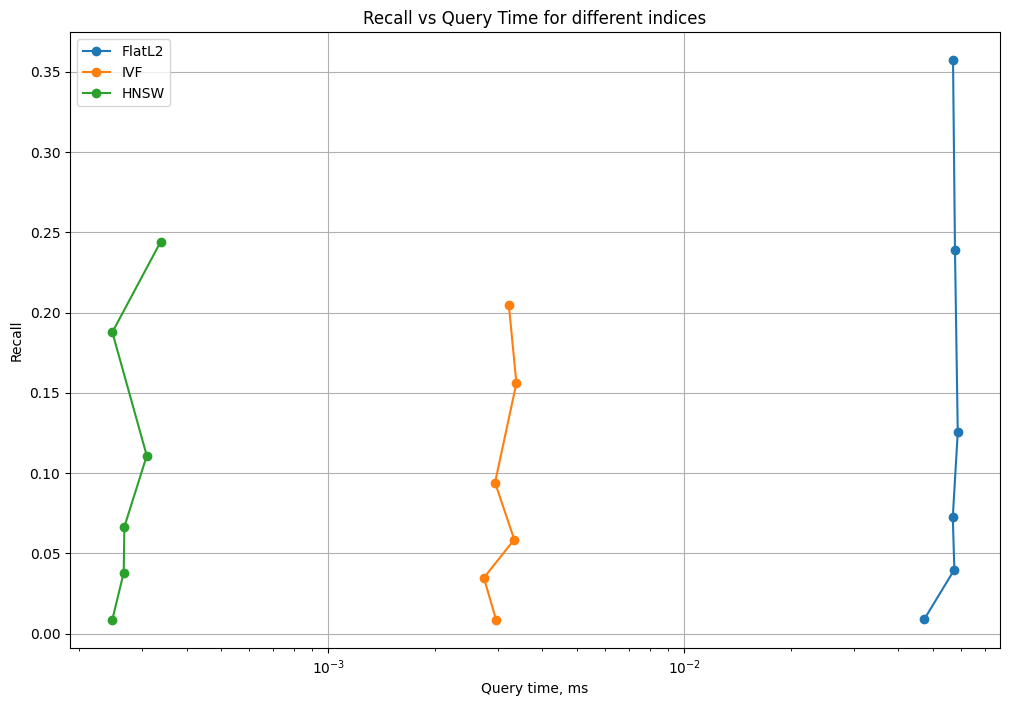

In [7]:
import matplotlib.pyplot as plt

# Recall@k 및 Query Time 시각화
plt.figure(figsize=(12, 8))

for name in results.keys():
    recall_values = [results[name][i][0] for i in range(len(k_values))]
    query_time_values = [results[name][i][1] for i in range(len(k_values))]
    
    plt.plot(query_time_values, recall_values, label=name, marker='o')

plt.xscale('log')
plt.xlabel('Query time, ms')
plt.ylabel('Recall')
plt.title('Recall vs Query Time for different indices')
plt.legend()
plt.grid(True)
plt.show()

1